# HW2

In [1]:
!gdown 1qCVYpb67RuzUbyrJ3w-ohtCf-tzZKTal
!gdown 1dW5SkCYIFbXmNe3xKv4EhrLPDPlXyIDy

Downloading...
From: https://drive.google.com/uc?id=1qCVYpb67RuzUbyrJ3w-ohtCf-tzZKTal
To: /content/train.txt
100% 9.87M/9.87M [00:00<00:00, 295MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dW5SkCYIFbXmNe3xKv4EhrLPDPlXyIDy
To: /content/test.txt
100% 5.80k/5.80k [00:00<00:00, 9.72MB/s]


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Question 1

Bayesian smoothing with dirichlet prior : 

p ( wi | wi-1 ) = ( C ( wi | wi-1 ) + (mu * Pbg) ) / C( wi-1) + mu

#### 1. Dependencies

In [3]:
import re

#### 2. Preprocessing

In [4]:
def preprocessing(file_name):
  sentences = []
  with open(file_name) as file:
    for line in file:
      line = re.sub(r"[\s]{2,}",' ',line)
      line = line.strip()
      words = line.split(' ')
      if len(words) > 2 :
        sentences.append(words)
  return sentences

In [5]:
train_sentences = preprocessing('train.txt')
test_sentences = preprocessing('test.txt')

In [6]:
print(len(train_sentences))
print(len(test_sentences))

188876
108


In [7]:
def word_count(sentences):
  word_count = 0
  word_dic = {}
  for sentence in sentences:
    for word in sentence:
      if word not in word_dic.keys():
        word_dic[word] = 1
      else:
        word_dic[word] += 1
      word_count+=1
  return word_dic, word_count

In [8]:
train_dic, train_count = word_count(train_sentences)
test_dic, test_count = word_count(test_sentences)

In [9]:
print(train_count)
print(test_count)

1308729
764


#### 3. Implementation

In [10]:
from nltk.util import ngrams
from nltk import FreqDist
import collections

In [11]:
def calc_bigram(sentences):
  bg_freqdist = FreqDist()
  for sentence in sentences:
    bigrams = ngrams(sentence,2)
    bg_freqdist.update(bigrams)
  bigram_dic = {k : v for k,v in collections.Counter(bg_freqdist).most_common()[:]}
  return bigram_dic

In [12]:
train_bigram_dic = calc_bigram(train_sentences)
test_bigram_dic = calc_bigram(test_sentences)

In [13]:
v = train_count
pbg = 1 / v
mu = 0.01

In [14]:
incomplete_sentences = [
     (2 ,'چون مشک سیه بود مرا هر دو'),
     (1,'گر خورد سوگند هم آن'),
     (1,'زانک نفس آشفته تر گردد از'),
     (1,'ازین زشت تر در جهان رنگ'),
     (2 ,'دوست در خانه و ما گرد'),
     (1,'شب است و شمع و شراب و')]


In [15]:
def predict_drichlet_prior(sentence):
  tokens = sentence.strip().split(' ')
  last_word = tokens[-1]
  last_word_count = train_dic[last_word]
  possible_words = {k: ((v + (mu * pbg))/(last_word_count + mu)) for k,v in train_bigram_dic.items() if k[0] == last_word}
  sorted_possible_words = {k:v for k,v in sorted(possible_words.items(), key = lambda item : item[1], reverse = True)}
  return list(sorted_possible_words.keys())[0][1]

In [16]:
for n,sentence in incomplete_sentences:
  print(sentence)

  if n > 1 :
    for i in range(0, n):
      possible_word= predict_drichlet_prior(sentence)
      sentence = " ".join([sentence, possible_word])
  else:
    possible_word= predict_drichlet_prior(sentence)
    sentence = " ".join([sentence, possible_word])

  print(sentence)
  print('-------')

چون مشک سیه بود مرا هر دو
چون مشک سیه بود مرا هر دو چشم من
-------
گر خورد سوگند هم آن
گر خورد سوگند هم آن را
-------
زانک نفس آشفته تر گردد از
زانک نفس آشفته تر گردد از آن
-------
ازین زشت تر در جهان رنگ
ازین زشت تر در جهان رنگ و
-------
دوست در خانه و ما گرد
دوست در خانه و ما گرد و از
-------
شب است و شمع و شراب و
شب است و شمع و شراب و از
-------


## Question 2

Perplexity of sentence and corpus : https://stats.stackexchange.com/questions/129352/how-to-find-the-perplexity-of-a-corpus#:~:text=As%20you%20said%20in%20your,We%20are%20done.&text=A

In [17]:
import math

In [18]:
def drichlet_prior(tokens,corpus_bigram_dic,corpus_unigram_dic,corpus_count):
  pbg = 1 / test_count
  sent_bigram = ngrams(tokens,2)
  prob = corpus_unigram_dic[tokens[0]] / corpus_count
  for w1,w2 in sent_bigram:
    prob *= ((corpus_bigram_dic.get((w1,w2),0) + (mu * pbg)) / (corpus_unigram_dic[w1] + mu))
  return prob   

In [19]:
corpus_prob = 0
for sentence in test_sentences:
  corpus_prob += math.log(drichlet_prior(sentence,test_bigram_dic,test_dic,test_count))
perplexity = 2 ** ((-1 / test_count) * corpus_prob)

In [20]:
perplexity

3.1369633871450855

## Question 3

#### 1. Dependencies

In [22]:
import tensorflow as tf
from nltk.util import ngrams
from keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.utils import to_categorical

#### 2. Create sequences based on length of input

In [23]:
def create_sequence(sentences,nn_input):
  seq_length = nn_input + 1
  sequences = []
  for sen in sentences:
    sequence = ngrams(sen,seq_length) 
    sequences.extend([list(x) for x in sequence])
  return sequences

In [24]:
train_sequences = create_sequence(train_sentences,2)
test_sequences = create_sequence(test_sentences,2)

In [25]:
print(train_sequences[0])
print(test_sequences[0])

['زانک', 'دل', 'یا']
['هل', 'تا', 'نفسی']


In [26]:
print(len(train_sequences))
print(len(test_sequences))

930977
548


#### 3. Tokenzing sequences to numbers

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sequences)
tokenizer.fit_on_texts(test_sequences)
test_sequences = tokenizer.texts_to_sequences(test_sequences)
train_sequences = tokenizer.texts_to_sequences(train_sequences)

In [28]:
print(train_sequences[0])
print(test_sequences[0])

[973, 17, 104]
[3005, 21, 1848]


In [29]:
print(np.shape(train_sequences))
print(np.shape(test_sequences))

(930977, 3)
(548, 3)


#### 4. Find out how many unique words we have

In [30]:
v_size = len(tokenizer.word_index) + 1

In [31]:
print(v_size)

56711


#### 5. Spliting sequences to input and output of neural net

In [32]:
train_sequences = np.array(train_sequences)
test_sequences = np.array(test_sequences)

In [33]:
input_train = train_sequences[:,:2]
output_train = train_sequences[:,-1]

In [34]:
input_test = test_sequences[:,:2]
output_test = test_sequences[:,-1]

In [35]:
print(np.shape(input_train))
print(np.shape(output_train))

(930977, 2)
(930977,)


In [36]:
output_train = output_train.reshape(-1,1)
print(np.shape(output_train))

(930977, 1)


In [37]:
print(np.shape(input_test))
print(np.shape(output_test))

(548, 2)
(548,)


In [38]:
output_test = output_test.reshape(-1,1)
print(np.shape(output_test))

(548, 1)


#### 6. make the output layer the probability distribution of all words using to catagorical

In [39]:
# We should use yield when we want to iterate over a sequence, but don’t want to store the entire sequence in memory.
# This allows its code to produce a series of values over time, rather than computing them at once and sending them back like a list.
def generator(X_, y_, batch_size, num_classes):
    num_samples = len(X_)
    while True: 
        for offset in range(0, num_samples, batch_size):
            X_batch_samples = X_[offset:offset+batch_size]
            y_batch_samples = y_[offset:offset+batch_size]
            y_batch_samples = to_categorical(y_batch_samples, num_classes)
            yield X_batch_samples, y_batch_samples

In [40]:
# we will lack ram since training set is big
# we conver to categorical using batches
train_generator = generator(input_train,output_train,2000,v_size)
output_test = to_categorical(output_test,num_classes=v_size)

In [41]:
output_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### 7. Model implementation

In [42]:
# sequential is a model
from keras.models import Sequential
# different type of layers
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint

In [43]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

class plot_loss(keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
        self.i = 0
        self.xs = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

  def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.xs.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.xs, self.losses, label="loss")
        plt.plot(self.xs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
plots = plot_loss()

In [44]:
model = Sequential()
# 50 is length of each word embedding 
# v_size is range of integer numbers we have (max number we can get as input of embedding)
model.add(Embedding(v_size , 50 ,input_length=2 ,name='Embedding-layer'))
model.add(Flatten())
model.add(Dense(int(v_size/2), activation='relu', name='Hidden-layer'))
model.add(Dense(v_size,activation='softmax',name='Output-layer'))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding-layer (Embedding)  (None, 2, 50)            2835550   
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 Hidden-layer (Dense)        (None, 28355)             2863855   
                                                                 
 Output-layer (Dense)        (None, 56711)             1608097116
                                                                 
Total params: 1,613,796,521
Trainable params: 1,613,796,521
Non-trainable params: 0
_________________________________________________________________


In [46]:
#check point saves the best model in a specific address
checkpoint = ModelCheckpoint('/content/drive/MyDrive/model-{epoch:03d}--{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True, mode='min')  

In [47]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

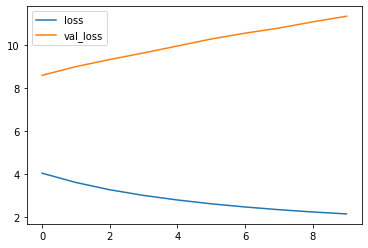


Epoch 10: val_loss did not improve from 6.93360
465/465 [==============================] - 235s 506ms/step - loss: 2.1421 - accuracy: 0.4850 - val_loss: 11.3451 - val_accuracy: 0.0766


In [50]:
model.fit(train_generator, batch_size=1000, epochs=10, steps_per_epoch=(len(train_sequences)//1000), validation_data=(input_test,output_test), callbacks=[plots,checkpoint])

#### 8. Testing model

In [51]:
best_model_path = '/content/drive/MyDrive/model-001--0.082117.h5'
model.load_weights(best_model_path)

In [52]:
# return word corresponding to input number
def convert_ID_to_word(ID):  
  for word, index in tokenizer.word_index.items():
    if np.int64(index) == ID:
      return word
  return

In [53]:
# create sentences from corresponding ids
def get_sentence_from_IDs(x):
  sent = ''
  for elem in x:
    sent += convert_ID_to_word(elem) + ' '
  return sent

In [64]:
sentences = ['چون مشک سیه بود مرا هر دو',
 'گر خورد سوگند هم آن',
 'زانک نفس آشفته تر گردد از',
 'ازین زشت تر در جهان رنگ',
 'دوست در خانه و ما گرد',
 'شب است و شمع و شراب و']

In [65]:
sentences_encodeed = tokenizer.texts_to_sequences(sentence)

In [70]:
# for sentences with one gap
X_test = np.array([sent[-2:] for sent in sentences_encodeed])
word_output = model.predict(X_test)
word_output = np.argmax(word_output, axis=1)

In [71]:
word_output

array([ 7,  7, 10,  1,  6, 14])

In [72]:
# for sentences with two gaps
w1 = np.array([sent[-1:] for sent in sentences_encodeed])
w2 = word_output
X_test = np.column_stack((w1, w2))
two_word_prediction = model.predict(X_test)
two_word_prediction = np.argmax(two_word_prediction, axis=1)

In [75]:
output = ''
for i in range(len(sentences)):
  output += sentences[i] + ' ' + convert_ID_to_word(word_output[i])
  if (i == 0 or i == 4):
    output += ' ' + convert_ID_to_word(two_word_prediction[i])
  output += '\n'
print(output)

چون مشک سیه بود مرا هر دو را به
گر خورد سوگند هم آن را
زانک نفس آشفته تر گردد از آن
ازین زشت تر در جهان رنگ و
دوست در خانه و ما گرد تو بر
شب است و شمع و شراب و می

